In [155]:
import sys
sys.path.insert(0, '/home/zahradnik/PycharmProjects/master_thesis')

In [156]:
from src.modules import conf, fit, df_columns, evl, preprocess
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import gpxpy
import haversine as hs
import numpy as np
import statsmodels.api as sm
from xgboost import XGBRFRegressor, XGBRegressor
warnings.simplefilter("ignore")

In [157]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [158]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [24, 8]
plt.rcParams['figure.dpi']

100.0

In [159]:
data = fit.load_pcls(
    athlete_name='zahradnik',
    activity_type='running',
    path_to_load=conf["Paths"]["pcl"],
)

100%|██████████| 386/386 [00:00<00:00, 2912.30it/s]


In [160]:
# ZONES ADD
for x in range(len(data)):
    data[x] = data[x][df_columns]
    mean_hr = np.mean(data[x].heart_rate)
    if mean_hr < 140:
        zone = 1
    elif mean_hr > 140 and mean_hr < 156:
        zone = 2
    elif mean_hr > 156 and mean_hr < 166:
        zone = 3
    elif mean_hr > 166 and mean_hr < 175:
        zone = 4
    elif mean_hr > 175:
        zone = 5
    data[x]['hr_zone'] = zone

In [161]:
low_dist = []
high_dist = []
for act in data:
    if np.max(act.distance) > 10000:
        high_dist.append(act)
    else:
        low_dist.append(act)
len(low_dist),len(high_dist)

(149, 237)

In [162]:
# race_index = fit.get_race_index(data, "2022-10-02-10-30") # HRADEC - 1:16 - 1:14
# race_index = fit.get_race_index(data, "2022-11-13-10-59") # VELKA KUNRATICKA 15:20 - 13:20
# race_index = fit.get_race_index(data, "2022-10-08-11-18") # BEROUNKA RUN 90:30 - 95:30
race_index = fit.get_race_index(data, "2022-12-31-11-00") # SILVESTRAK 18:20 - 17:20
print(race_index)
train_df = fit.clean_data(pd.concat(high_dist[0:race_index]))
test_df = data[race_index]
len(train_df),len(test_df)

369


(753174, 1037)

In [163]:
speed_train = train_df.enhanced_speed
speed_test = test_df.enhanced_speed

heart_train = train_df.heart_rate
heart_test=test_df.heart_rate

cad_train = train_df.cadence
cad_test=test_df.cadence

train_df.drop("enhanced_speed",axis=1,inplace=True)
train_df.drop("heart_rate",axis=1,inplace=True)

test_df.drop("enhanced_speed",axis=1,inplace=True)
test_df.drop("heart_rate",axis=1,inplace=True)
#
train_df.drop("cadence",axis=1,inplace=True)
test_df.drop("cadence",axis=1,inplace=True)

In [164]:
from feature_engine.datetime import DatetimeFeatures
train_df['date'] = train_df.index
test_df['date'] = test_df.index
dtf = DatetimeFeatures(features_to_extract=['month','week','hour','minute','second'])
train_df= dtf.fit_transform(train_df)
test_df= dtf.fit_transform(test_df)

In [165]:
from feature_engine.timeseries.forecasting import WindowFeatures
lagged_cols = ['slope_steep','slope_ascent','slope_descent']
lagged = 18
for lag in range(1,lagged):
    wft = WindowFeatures(variables=lagged_cols,
                         window=lag)
    train_df = wft.fit_transform(train_df)
    test_df = wft.fit_transform(test_df)

In [166]:
for colname in train_df.columns:
    if 'mean' in colname:
        train_df[colname].fillna(0,inplace=True)
        test_df[colname].fillna(0,inplace=True)

1.642583797036844


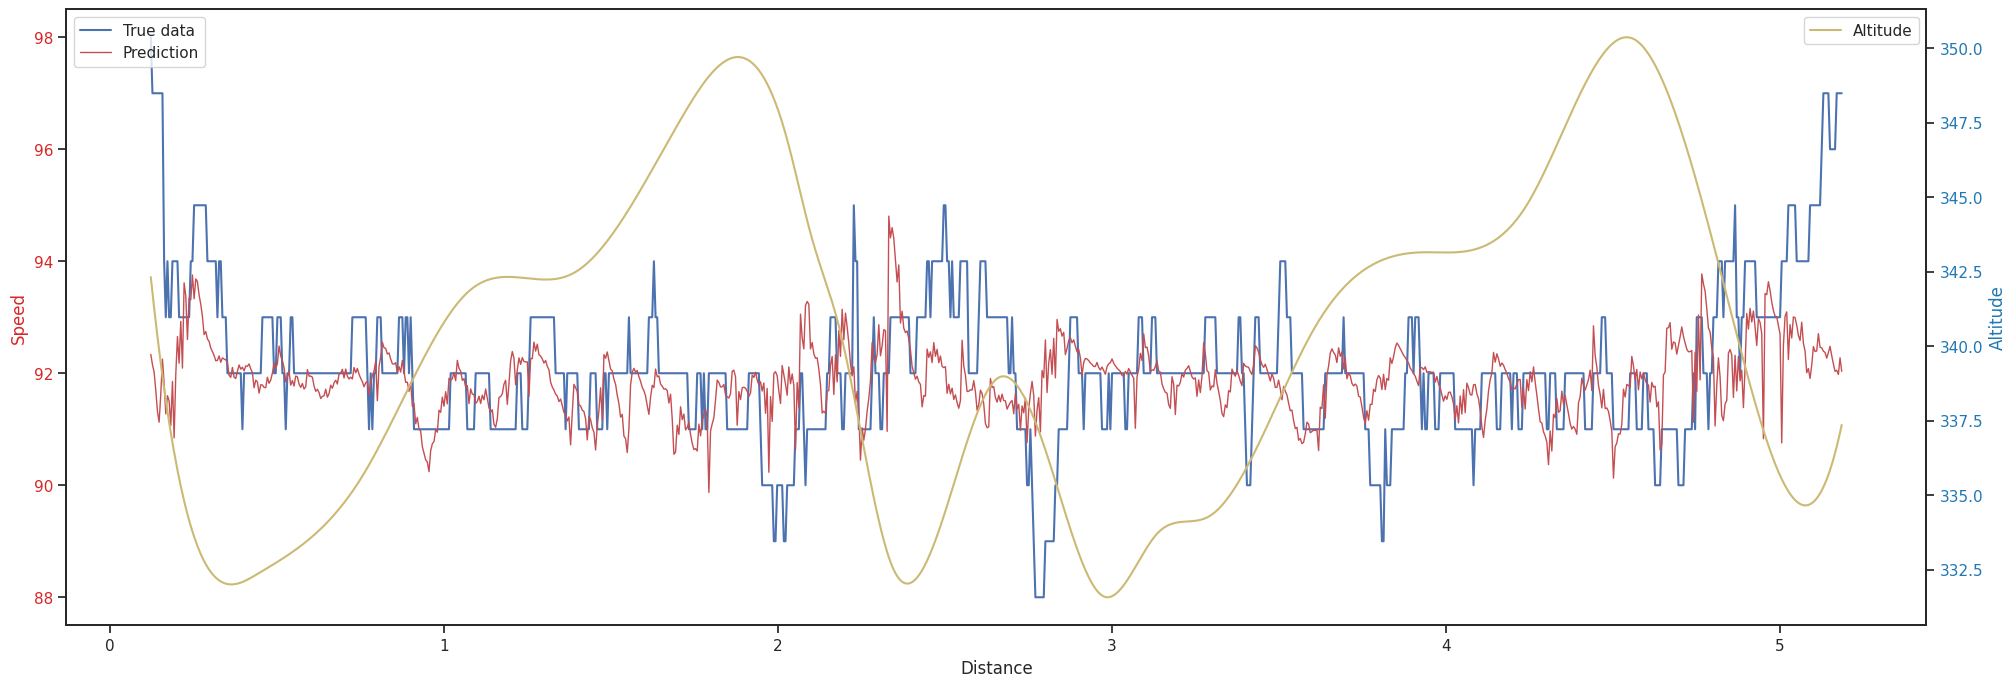

In [167]:
from sklearn.linear_model import Ridge, LinearRegression, RidgeCV,ElasticNetCV, LassoCV
clf = RidgeCV()
percent_delay = int(len(test_df) * 0.02) ## 2% delay
clf.fit(train_df, cad_train)
y_pred_cad =clf.predict(test_df)
_, _ = evl.plot(df=test_df[percent_delay:],pred=y_pred_cad[percent_delay:],endog='enhanced_speed',true_data=cad_test[percent_delay:])
print(evl.rmse(actual=cad_test,predicted=y_pred_cad))

In [168]:
train_df['cadence'] = cad_train
test_df['cadence'] = y_pred_cad

In [169]:
from feature_engine.timeseries.forecasting import WindowFeatures
lagged_cols = ['cadence']
lagged = 18
for lag in range(1,lagged):
    wft = WindowFeatures(variables=lagged_cols,
                         window=lag)
    train_df = wft.fit_transform(train_df)
    test_df = wft.fit_transform(test_df)

In [170]:
train_df = fit.clean_data(train_df)
test_df = fit.clean_data(test_df)

10.319303874173027


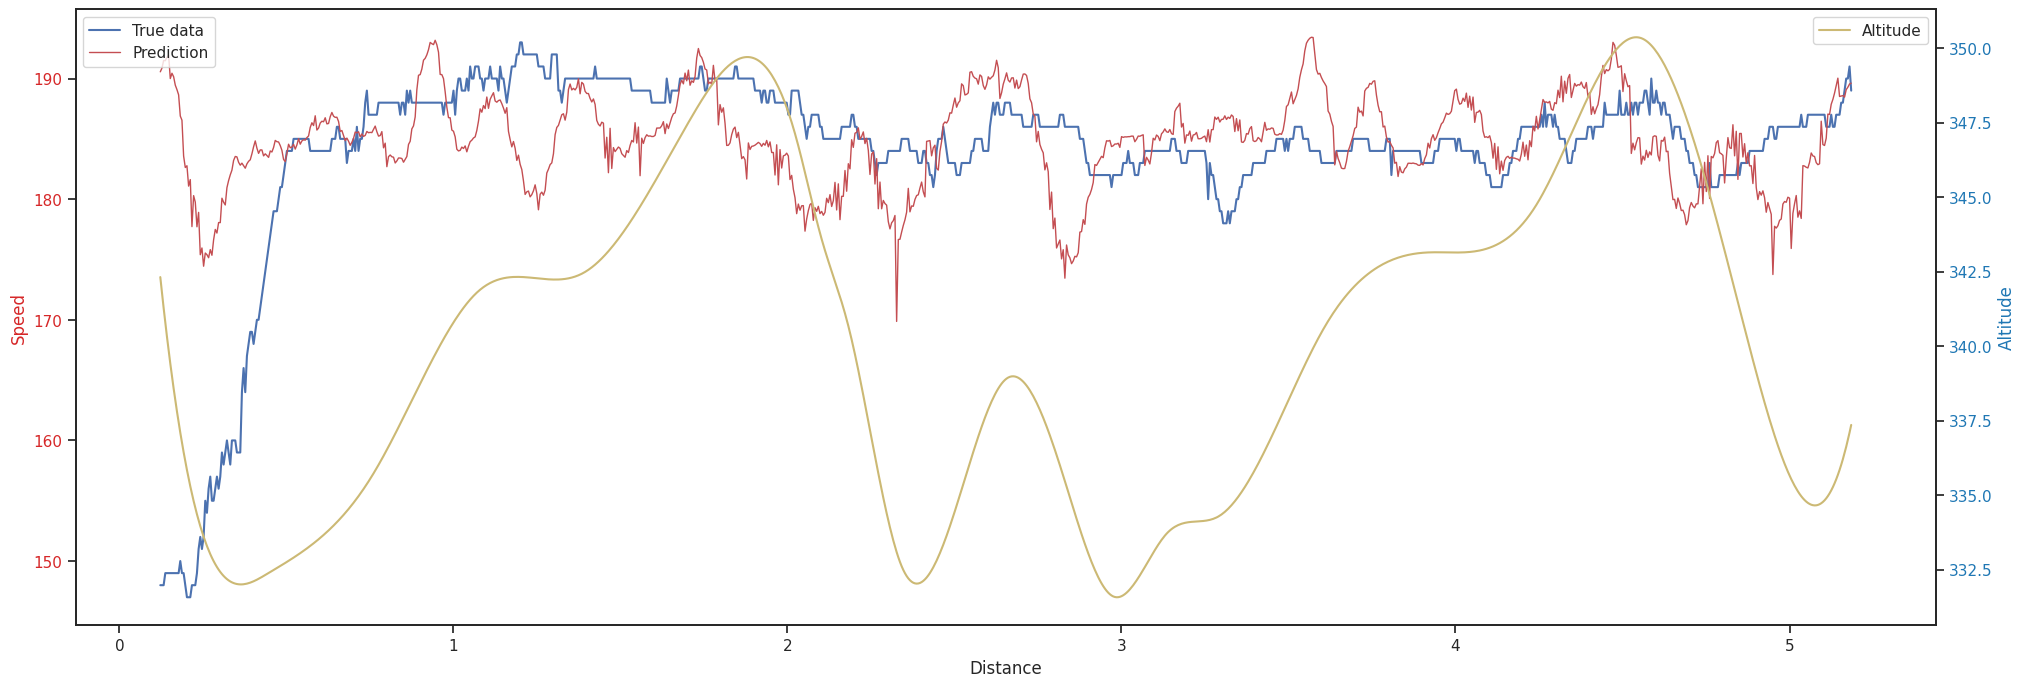

In [171]:
from sklearn.linear_model import Ridge, LinearRegression, ElasticNetCV
clf = RidgeCV()
percent_delay = int(len(test_df) * 0.02) ## 2% delay
clf.fit(train_df, heart_train)
y_pred_hr =clf.predict(test_df)
_, _ = evl.plot(df=test_df[percent_delay:],pred=y_pred_hr[percent_delay:],endog='enhanced_speed',true_data=heart_test[percent_delay:])
print(evl.rmse(actual=heart_test,predicted=y_pred_hr))

In [172]:
train_df['heart_rate'] = heart_train
test_df['heart_rate'] = y_pred_hr

In [173]:
from feature_engine.timeseries.forecasting import WindowFeatures
lagged_cols = ['heart_rate']
lagged = 18
for lag in range(1,lagged):
    wft = WindowFeatures(variables=lagged_cols,
                         window=lag)
    train_df = wft.fit_transform(train_df)
    test_df = wft.fit_transform(test_df)

In [174]:
from feature_engine.timeseries.forecasting import WindowFeatures
lagged_cols = ['heart_rate']
lagged = 4
for lag in range(1,lagged):
    wft = WindowFeatures(variables=lagged_cols,
                         window=lag,
                         periods=7)
    train_df = wft.fit_transform(train_df)
    test_df = wft.fit_transform(test_df)

In [175]:
from scipy.ndimage import uniform_filter1d
for x in range(10,110,10):
    train_df[f'moved_heart_rate_{x}'] = uniform_filter1d(train_df.heart_rate, size=x)
    test_df[f'moved_heart_rate_{x}'] = uniform_filter1d(test_df.heart_rate, size=x)

In [176]:
train_df = fit.clean_data(train_df)
test_df = fit.clean_data(test_df)

1.061339733901778


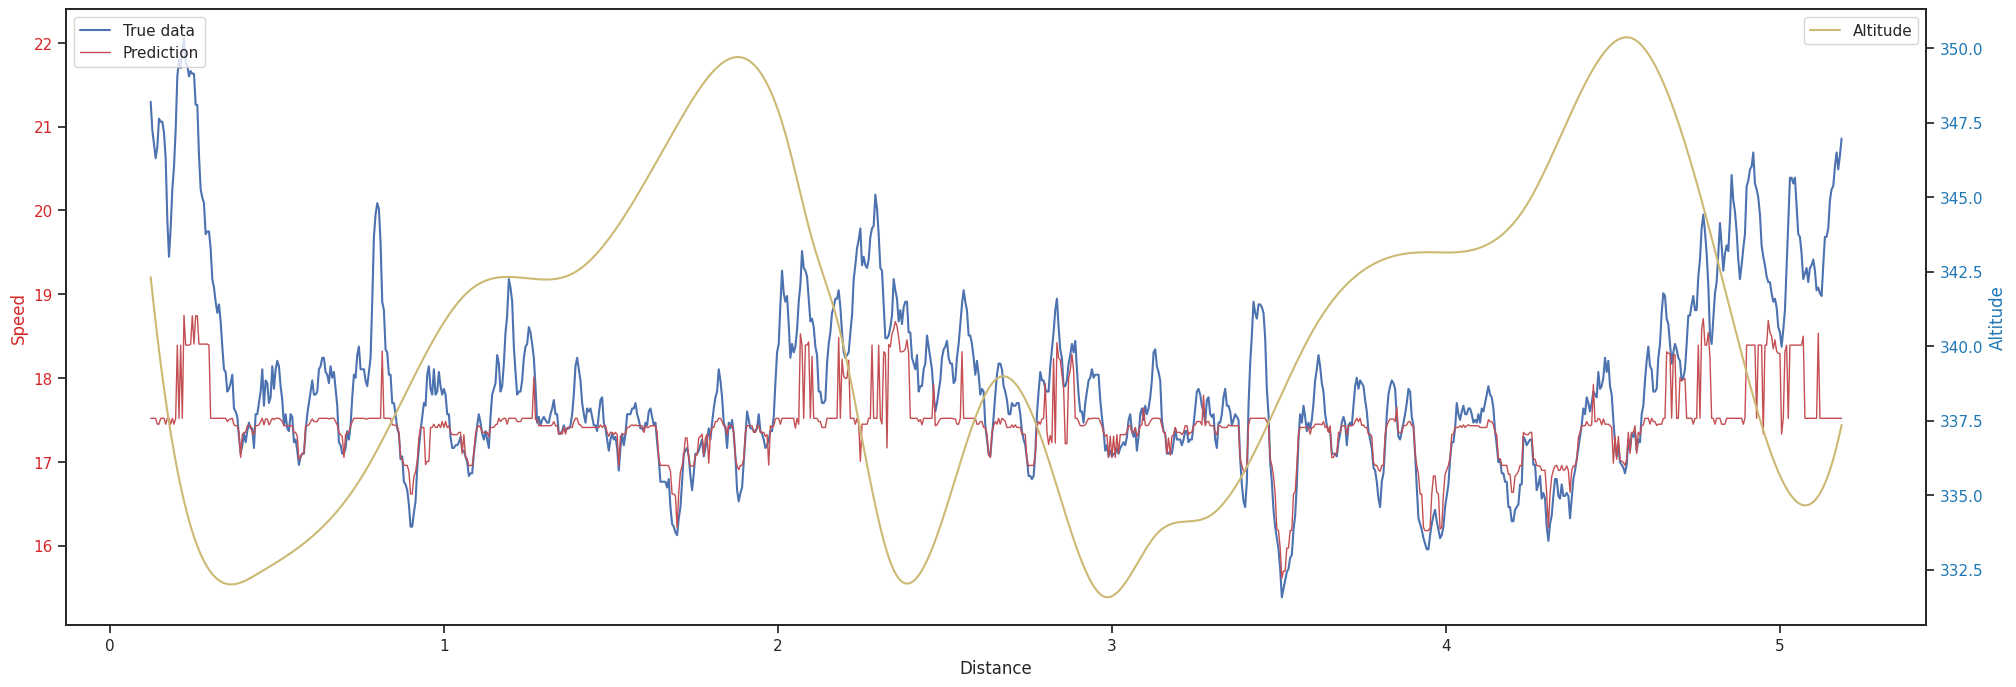

In [177]:
from sklearn.linear_model import Ridge, LinearRegression, RidgeCV
clf = XGBRFRegressor()
percent_delay = int(len(test_df) * 0.02) ## 2% delay
clf.fit(train_df, speed_train)
y_pred_ridge =clf.predict(test_df)
_, _ = evl.plot(df=test_df[percent_delay:],pred=y_pred_ridge[percent_delay:],endog='enhanced_speed',true_data=speed_test[percent_delay:])
print(evl.rmse(actual=speed_test,predicted=y_pred_ridge))

In [178]:
import math
np.mean(speed_test),np.mean(y_pred_ridge),max(test_df.distance)
time = ((max(test_df.distance)/1000) / np.mean(y_pred_ridge))*60
minutes = math.floor(time)
seconds = round((time-minutes)*60)
f'Final time: {minutes}:{seconds}'

'Final time: 17:50'